# 1. As características de um problema não-supervisionado

O modelo nao-supervisionado funciona se baseando em convergir a partir da similaridade de atributos entre entidades diferentes. Por exemplo, a partir de frutas com atributos semelhantes (tamanho, cor, formato, etc) o não-supervisionado agrupa. Um dos maiores desafios deste tipo de modelo é que não existe resposta errada, todo algoritmo de clusterização retornará um cluster. Outro desafio é que toda a fundamentação de machine learning se baseia no erro e, por isso, a performance dos modelos são medidos mais na prática. 

Outro ponto importante é que, em geral, clusterização é o meio e não o fim. A ideia é sumarizar os dados por algum motivo. Por exemplo, no caso aqui são os "Insiders", que é um grupo reduzido a partir de um grande grupo. 

# PA 005 - High Value Customer Identification (Insiders)

## 0.0. Planejamento da Solução (IoT)

### 0.1. Input (Entrada)

1. Problema de Negócio
    - Selecionar os clientes mais valiosos para integrar um programa de fidelização
    
    
2. Conjunto de dados
    - Vendas de um e-commerce online durante um periodo de um ano.

### 0.2. Output (Saída)

1. A indicação das pessoas que farão parte do programa de Insiders
    - Lista: client_id | is_insider


2. Relatório com as respostas das perguntas de negócio
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

### 0.3 Tasks (Tarefas)

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegível? O que são clientes de maior "valor"?
        - Faturamento
            - Alto ticket médio
            - Alto LTV (Life Time Value)
            - Baixa Recência (baixo tempo entre duas compras)
            - Alto Basket Size (tamanho da cesta de compras)
            - Baixa probabilidade de churn (churn é quando a empresa para de utilizar seu serviço)
            - Alta propensão de compra
            
        - Custo
            - Baixa taxa de devolução
            
        - Experiência de Compra
            - Média alta das avaliações
            
            
2. Quantos clientes farão parte do grupo?
    - Número total de clientes
        - % do grupo Insiders
    
    
3. Quais as principais características desses clientes ?
    - Escrever características dos clientes
        - Idade
        - Localização 
    
    - Características do consumo
        - Features da clusterização


4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Faturamento total do ano
    - Faturamento do grupo insiders


5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - LTV do grupo Insiders
    - Séries temporais (ARIMA, ARMA, HoltWinter, etc)
    

6. Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Definir a periodicidade (1 mês, 3 meses, etc)
    - A pessoa precisa ser similar ou parecido com uma pessoa do grupo


7. Quais as condições para uma pessoa ser removida do Insiders ?
    - Definir a periodicidade (1 mês, 3 meses, etc)
    - A pessoa precisa ser disimilar ou não-parecido com uma pessoa do grupo


8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Teste A/B
    - Teste A/B Bayesiano
    - Teste de Hipóteses


9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferência de Compra
    - Frete Grátis
    - Visita a empresa


# 0.0 Imports

In [1]:
import pandas  as pd
import numpy   as np
import seaborn as sns

from matplotlib      import pyplot as plt
from IPython.display import HTML
from sklearn import cluster as c
from sklearn import metrics as m
from plotly import express as px
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import umap.umap_ as umap

C:\Users\t.mesha09\Anaconda3\envs\pa005-programa_de_fidelidade\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container {width: 100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Load Dataset

In [3]:
# read data
df_raw = pd.read_csv('../data/Ecommerce.csv', encoding='unicode_escape')

# drop exatra column
df_raw = df_raw.drop('Unnamed: 8', axis=1)

In [4]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0 Descrição dos dados

## 1.1 Rename Columns

In [5]:
df1 = df_raw.copy()

In [6]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [7]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

In [8]:
df1.sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
393910,570861,22393,PAPERWEIGHT VINTAGE COLLAGE,6,10-Oct-17,2.55,14775.0,United Kingdom


## 1.2 Data Dimensions

In [9]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'. format(df1.shape[1]))

Number of rows: 541909
Number of columns: 8


## 1.3 Data Types

In [10]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [11]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

O fato de ter 135k customer_id sem identificação é um problema, uma vez que o objetivo é construir clusters identificando os clientes. A princípio, serão removidos 135k de linhas, mas é importante entender o que houve e o motivo de estarem assim.

## 1.5 Replace NA

In [12]:
# remove NA

df1 = df1.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.2f}'.format(1 - (df1.shape[0]/df_raw.shape[0])))

Removed data: 0.25


Ou seja, 25% do dataset foi removido.

In [13]:
df1.shape

(406829, 8)

Ainda assim, segue-se com mais de 400k de linhas, não será impeditivo do projeto seguir.

In [14]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6 Change Dtypes

In [15]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [16]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype('int64')

In [17]:
df1.sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
335498,566290,84030E,ENGLISH ROSE HOT WATER BOTTLE,1,2017-09-09,4.25,14456,United Kingdom


In [18]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.7 Descriptive Statistics

In [19]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [20]:
d = num_attributes.describe()
d1 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d2 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
df_num = pd.concat([d,d1,d2]).T.reset_index()
df_num.columns = ['attributes', 'count', 'mean', 'std','min','25%','50%', '75%', 'max', 'skew', 'kurtosis']
df_num

,attributes,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
0,quantity,406829.0,12.061303,248.693370,-80995.0,2.00,5.00,12.00,80995.0,0.182663,94317.563673
1,unit_price,406829.0,3.460471,69.315162,0.0,1.25,1.95,3.75,38970.0,452.219019,246924.542988
2,customer_id,406829.0,15287.690570,1713.600303,12346.0,13953.00,15152.00,16791.00,18287.0,0.029835,-1.179982


#### 1.7.1.1 Numerical Attributes - Investigating

1. Quantity negativa (pode ser devolução)
2. Preço unitário igual a zero (pode ser promoção?)

### 1.7.2 Categorical Attributes

In [21]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


In [33]:
# invoice number
print(f"Total de parâmetros com caracter diferente de número: {len(cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'invoice_no'].drop_duplicates() ) }")

df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]
print(f'Total de números negativos: {len(df_letter_invoices[df_letter_invoices["quantity"] > 0])}')

Total de parâmetros com caracter diferente de número: 3654
Total de números negativos: 0


Existe um total de 3654 invoice_no que estão com algum tipo de letra no nome, o que impede de fazer a conversão para número. Além disso, todos as quantidades estão negativas nesta situação, o que é estranho, uma vez que os valores de compras precisam ser positivos. Estes valores negativos podem ser considerados devoluções de produtos.

In [36]:
# stock_code
print(len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'stock_code'] ))

# total com todos os parametros sendo string
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

35809


array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

Existem variáveis que podem ser sujeiras, não indicam nada para gente. 

In [37]:
# description

# Delete description

In [45]:
# Country

# total de paises
print(f"Total de países: {(len(df1['country'].unique()))}")

#representatividade dos paises nas compras por pais
print("Lista dos Países: ")
df1['country'].value_counts(normalize=True)

Total de países: 37
Lista dos Países: 


United Kingdom          0.889509
Germany                 0.023339
France                  0.020871
EIRE                    0.018398
Spain                   0.006226
Netherlands             0.005828
Belgium                 0.005086
Switzerland             0.004614
Portugal                0.003638
Australia               0.003095
Norway                  0.002669
Italy                   0.001974
Channel Islands         0.001863
Finland                 0.001708
Cyprus                  0.001529
Sweden                  0.001136
Austria                 0.000986
Denmark                 0.000956
Japan                   0.000880
Poland                  0.000838
USA                     0.000715
Israel                  0.000615
Unspecified             0.000600
Singapore               0.000563
Iceland                 0.000447
Canada                  0.000371
Greece                  0.000359
Malta                   0.000312
United Arab Emirates    0.000167
European Community      0.000150
RSA       

# 2.0 Data Filtering

In [46]:
df2 = df1.copy()

In [47]:
# unit price > 0.01
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# stock code != [POST, D, M, DOT, CRUK]
df2 = df2[~df2['stock_code'].isin(['Post', 'D', 'M', 'DOT', 'CRUK'])]

# description
df2 = df2.drop(columns='description', axis=1)

# map
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

## quantity - Negative number means product returns
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] > 0, :]



# 3.0 Feature Engineering

In [48]:
df3 = df2.copy()

## 3.1 Feature Creation

In [49]:
df3.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,6,2016-11-29,3.39,17850,United Kingdom


Será criado uma tabela de referência, com a menor granularidade possível

In [50]:
df_ref = df3.drop(['invoice_no', 'stock_code', 
                   'quantity', 'invoice_date', 'unit_price', 
                   'country'], axis = 1).drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [51]:
# Gross Revenue (Faturamento) = quantity * price
df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:,'quantity']*df2_purchase.loc[:,'unit_price']

# Monetary (Quanto esta pessoa gastou na loja)
df_monetary = df2_purchase.loc[:,['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()

# Adicionando no datafram de referencia
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
df_ref.isna().sum()

C:\Users\t.mesha09\AppData\Local\Temp\ipykernel_25544\1121802770.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:,'quantity']*df2_purchase.loc[:,'unit_price']


customer_id       0
gross_revenue    27
dtype: int64

Existem 27 clientes que nunca compraram nada mas devolveram produtos, por isso o valor de 27 para NA.

In [52]:
# Recency - Last Day Purchase
# Como o dataset é antigo, será escolhido a data como a última data de compra do dataset. Esta data servirá de referencia, uma vez que o recorte dos dados é de dois anos atrás.
# em um projeto real, é selecionado o datetime.today(), selecionando assim a data de HOJE.
df_recency = df2_purchase[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2_purchase['invoice_date'].max()-df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
dtype: int64

In [53]:
# Frequency
df_frequency = df2_purchase[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_frequency, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
dtype: int64

In [54]:
# Avg Ticket
df_avg_ticket = df2_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_avg_ticket['avg_ticket'] = np.round(df_avg_ticket['avg_ticket'],2)
df_ref = pd.merge(df_ref, df_avg_ticket, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
dtype: int64

In [55]:
# number of returns
df_returns = df2_returns[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no': 'returns'})
df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['returns'].isna(),'returns'] = 0
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
returns           0
dtype: int64

In [56]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns
0,17850,5391.21,372.0,34.0,18.15,1.0
1,13047,3232.59,56.0,9.0,18.90,7.0
2,12583,7281.38,2.0,15.0,29.48,3.0
3,13748,948.25,95.0,5.0,33.87,0.0
4,15100,876.00,333.0,3.0,292.00,3.0


# 4.0 EDA - Exploratory Data Analysis

In [57]:
df4 = df_ref.dropna().copy()

In [58]:
df4.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
avg_ticket       0
returns          0
dtype: int64

# 5.0 Data Preparation

In [59]:
df5 = df4.copy()

In [60]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns
0,17850,5391.21,372.0,34.0,18.15,1.0
1,13047,3232.59,56.0,9.0,18.90,7.0
2,12583,7281.38,2.0,15.0,29.48,3.0
3,13748,948.25,95.0,5.0,33.87,0.0
4,15100,876.00,333.0,3.0,292.00,3.0


In [61]:
from sklearn import preprocessing as pp

In [62]:
ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
df5['invoice_no'] = ss.fit_transform(df5[['invoice_no']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])
df5['returns'] = ss.fit_transform(df5[['returns']])

In [76]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns
0,17850,0.373941,2.791877,3.880591,-0.033923,0.105941
1,13047,0.132932,-0.360703,0.618235,-0.033413,3.120554
2,12583,0.584978,-0.899435,1.401201,-0.026212,1.110812
3,13748,-0.122114,0.028381,0.096258,-0.023224,-0.396495
4,15100,-0.130181,2.402793,-0.164730,0.152464,1.110812


# 6.0 Feature Selection

In [63]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tuning

In [64]:
X = df6.drop(columns=['customer_id'])

In [65]:
X.head()

,gross_revenue,recency_days,invoice_no,avg_ticket,returns
0,0.373941,2.791877,3.880591,-0.033923,0.105941
1,0.132932,-0.360703,0.618235,-0.033413,3.120554
2,0.584978,-0.899435,1.401201,-0.026212,1.110812
3,-0.122114,0.028381,0.096258,-0.023224,-0.396495
4,-0.130181,2.402793,-0.164730,0.152464,1.110812


## 7.1 Within-Cluster Sum of Squares (WSS)

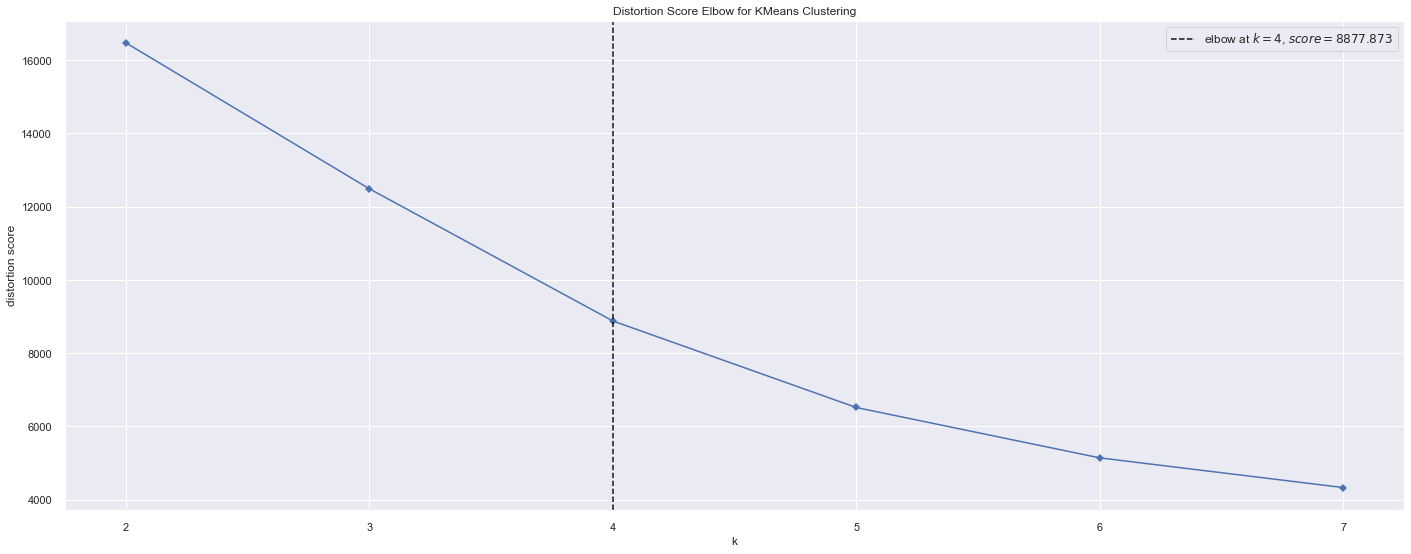

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [66]:
clusters = [2,3,4,5,6,7]
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show()

## 7.2 Silhouette Score (SS)

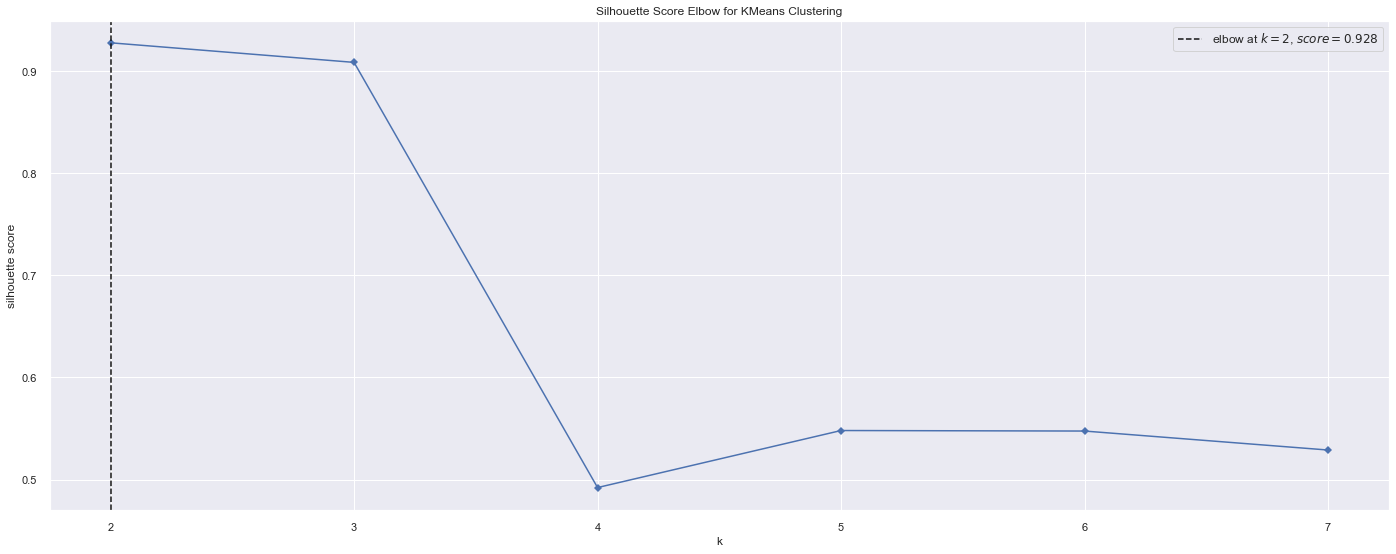

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [67]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show()

Então, o WSS indicou um total de 3 clusters, enquanto a SS indicou 2 clusters. A escolha é preferível ser a partir da SS, já que considera a distância intra cluster e entre clusters. Porém, se observar os valores de score para a SS, usar 2 ou 3 não influenciará muito negativamente, já que os valores de score não são tão diferentes. Por isso, será optado por utilizar k = 3 a princípio.

## 7.3 Silhouette Analysis

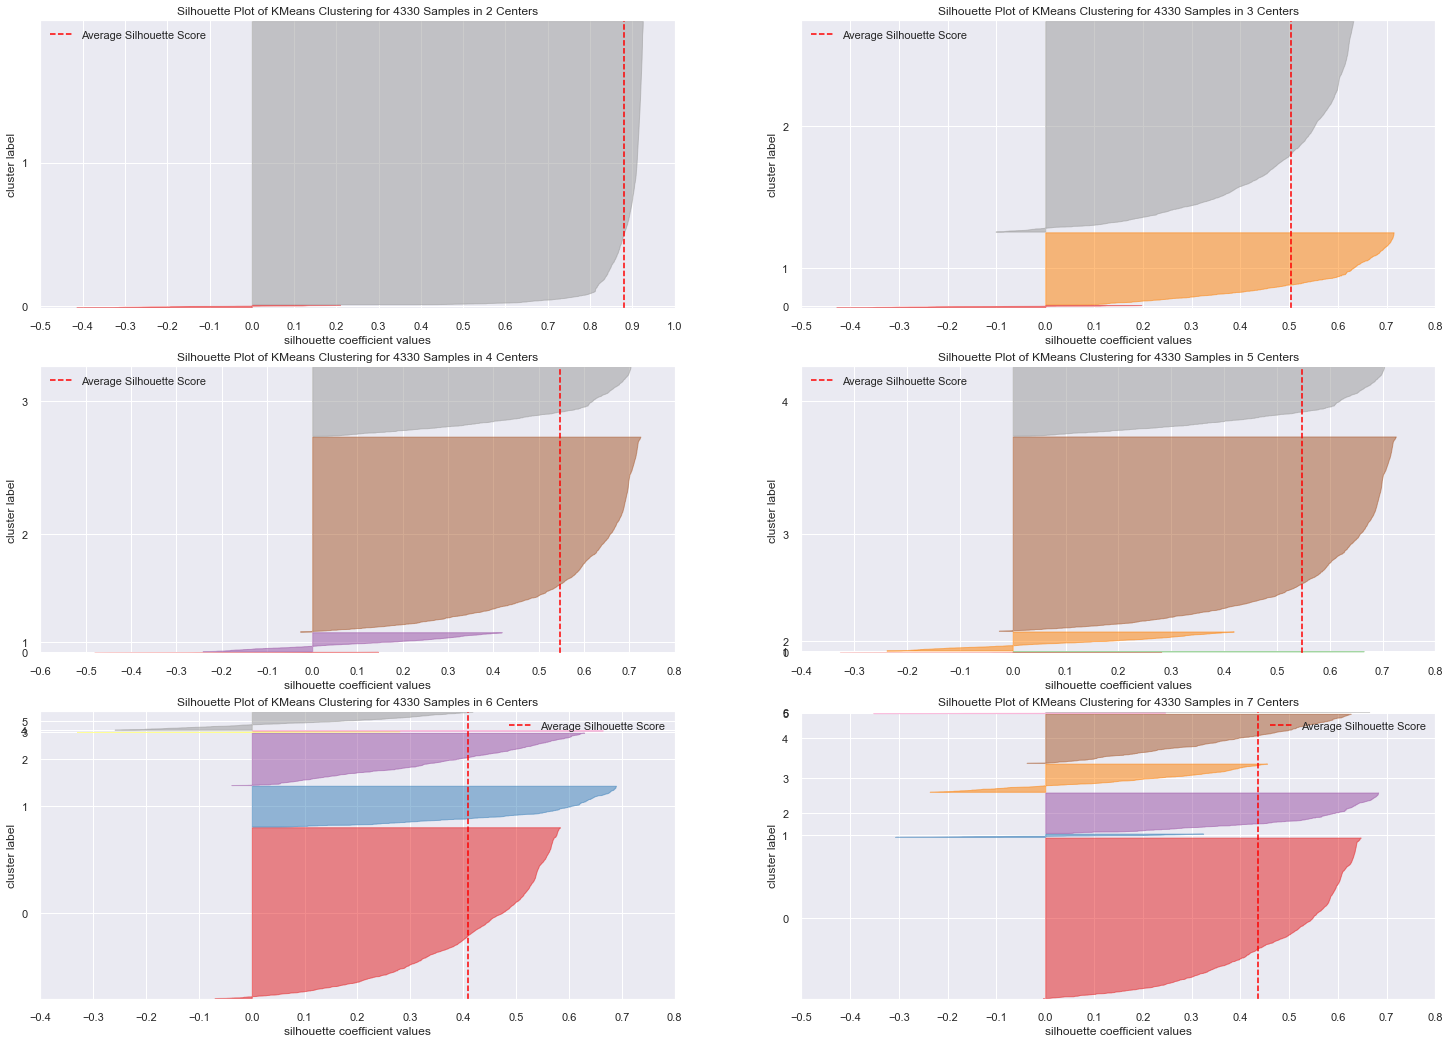

In [68]:
fig,ax = plt.subplots(3,2,figsize=(25,18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k,2)
    visualizer = SilhouetteVisualizer(km, color='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

A princípio, existe um cluster muito maior que os outros que engloba a maior parte dos dados. As métricas não funcionarão bem.

# 8.0 Model Training

## 8.1 K-Means

In [69]:
# model definition
k = 6
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 8.1.1 Cluster Validation

In [70]:
print(  f'WSS Value: {kmeans.inertia_}')
print(f'Silhouette Score: {m.silhouette_score(X, labels, metric="euclidean")}')

WSS Value: 6055.382205098947
Silhouette Score: 0.4096373819884112


# 9.0 Cluster Analysis

In [71]:
df9 = df6.copy()
df9['cluster'] = labels

## 9.1 Visualization Inspectionb

In [72]:
 #fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
 #fig.show()

## 9.2 Visualization Silhouette Visualizer

C:\Users\t.mesha09\Anaconda3\envs\pa005-programa_de_fidelidade\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


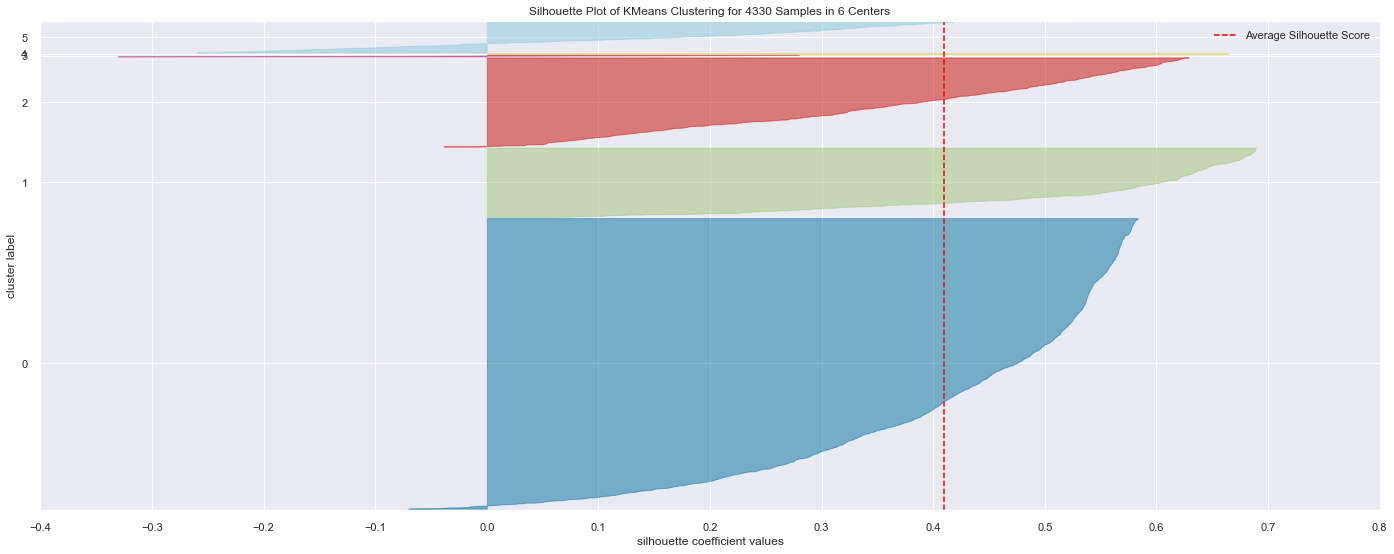

In [73]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

In [77]:
#df_viz = df9.drop(columns='customer_id', axis=1)
#sns.pairplot(df_viz, hue='cluster')

## 9.3 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

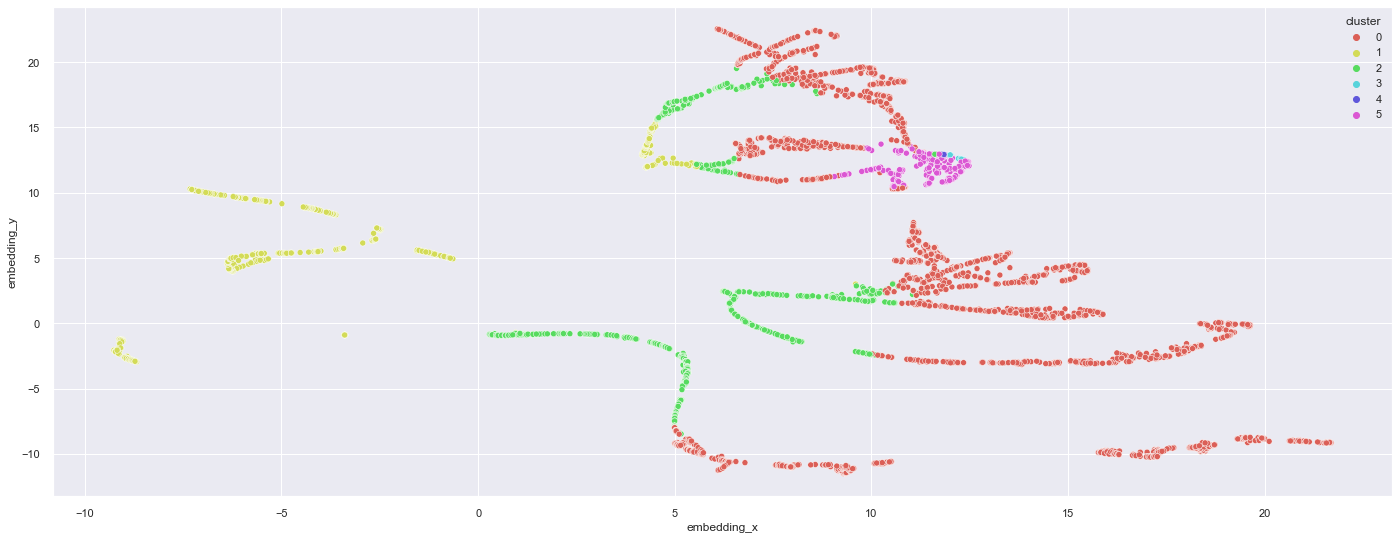

In [75]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', 
                hue='cluster', 
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())), 
                data=df_viz)

## 9.4 Cluster Profile

In [76]:
# number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id']/df_cluster['customer_id'].sum() )

# average gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_gross_revenue, how='inner', on='cluster')

# average recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_recency_days, how='inner', on='cluster')

# average invoice_no
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_invoice_no, how='inner', on='cluster')

# average ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,4071,93.115279,946.696250,96.969295,3.641120,25.359654
1,1,6,0.137237,182181.981667,7.166667,89.000000,253.626345
2,2,28,0.640439,42614.387143,6.178571,57.821429,162.862605
3,3,267,6.107045,8089.028652,20.280899,19.528090,62.783157


Se fosse da forma como está definido, o cluster 1, referente aos insiders, que é o cluster com menor recency e maior gross_revenue, seria formado por apenas 6 pessoas.
Além disso, este grupo de 6 pessoas tem um gasto de $182k em média, o que é muito acima de qualquer um dos outros clusters.
Este mesmo cluster tem um tempo de retorno em compra de 7 dias, o que é muito inferior aos outros, o que é excelente para o negócio. Além de ter um total de 89 compras.

### Cluster 01: (Candidato à Insider)
    - Número de customers: 6 (0.14% dos customers)
    - Recência em média: 7 dias
    - Compras em média: 89 compras
    - Receita em média: $182.182,00
    
### Cluster 02:

    - Número de customers: 31 (0.71% dos customers)
    - Recência em média: 14 dias
    - Compras em média: 53 compras
    - Receita em média: $40.543,52
    
### Cluster 03:

    - Número de customers: 4.335 (99% dos customers)
    - Recência em média: 92 dias
    - Compras em média: 5 compras
    - Receita em média: $1.372,57

# 10.0 Deploy to Production